# The intent of this notebook is to familiarize ourselves with the data, do some exploratory analysis and to construct timeseries and other data for further analysis by the team

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import datetime
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

#set default plot characterstics and colors
from matplotlib import rcParams

import prep_data

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# import findspark
# findspark.init()
# import pyspark
# sc = pyspark.SparkContext(appName="Spark1")

/Users/ta24418/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Loading the data with some initial cleaning (h/t CS109Hubway for getting me started on this and for having the data loaded to github already)

In [2]:
stations_df = prep_data.stations('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/hubway_stations.csv')
stations_df.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


In [3]:
stations_df.shape

(142, 7)

In [4]:
trips_df = prep_data.trips('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/tripsthrough2012.csv')
trips_df.head()

,index,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,...,st_hour,end_hour,st_minute,end_minute,st_month,end_month,st_daydate,end_daydate,st_weekday,end_weekday
0,140521,140522,157655,Closed,189,2012-03-13 18:31:00,29.0,2012-03-13 18:34:00,18.0,B00094,...,18,18,1111,1114,3,3,2012-03-13,2012-03-13,1,1
1,140522,140524,157657,Closed,704,2012-03-15 00:00:00,40.0,2012-03-15 00:12:00,40.0,B00082,...,0,0,0,12,3,3,2012-03-15,2012-03-15,3,3
2,140523,140523,157656,Closed,1700,2012-03-15 00:00:00,7.0,2012-03-15 00:28:00,15.0,B00603,...,0,0,0,28,3,3,2012-03-15,2012-03-15,3,3
3,140524,140525,157658,Closed,1411,2012-03-15 00:00:00,41.0,2012-03-15 00:24:00,36.0,B00278,...,0,0,0,24,3,3,2012-03-15,2012-03-15,3,3
4,140525,140526,157659,Closed,251,2012-03-15 00:03:00,43.0,2012-03-15 00:07:00,40.0,B00076,...,0,0,3,7,3,3,2012-03-15,2012-03-15,3,3


In [5]:
weekdaystations = trips_df.loc[trips_df.st_weekday < 5]
weekdaystations.head()

,index,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,...,st_hour,end_hour,st_minute,end_minute,st_month,end_month,st_daydate,end_daydate,st_weekday,end_weekday
0,140521,140522,157655,Closed,189,2012-03-13 18:31:00,29.0,2012-03-13 18:34:00,18.0,B00094,...,18,18,1111,1114,3,3,2012-03-13,2012-03-13,1,1
1,140522,140524,157657,Closed,704,2012-03-15 00:00:00,40.0,2012-03-15 00:12:00,40.0,B00082,...,0,0,0,12,3,3,2012-03-15,2012-03-15,3,3
2,140523,140523,157656,Closed,1700,2012-03-15 00:00:00,7.0,2012-03-15 00:28:00,15.0,B00603,...,0,0,0,28,3,3,2012-03-15,2012-03-15,3,3
3,140524,140525,157658,Closed,1411,2012-03-15 00:00:00,41.0,2012-03-15 00:24:00,36.0,B00278,...,0,0,0,24,3,3,2012-03-15,2012-03-15,3,3
4,140525,140526,157659,Closed,251,2012-03-15 00:03:00,43.0,2012-03-15 00:07:00,40.0,B00076,...,0,0,3,7,3,3,2012-03-15,2012-03-15,3,3


In [6]:
weekendstations = trips_df.loc[trips_df.st_weekday >= 5]

#### This is the beginning of our look at the top five connected stations in total, the results may change as we investigate this per hour

In [7]:
grouped_trips = weekdaystations.groupby(['strt_statn','end_statn'])
# grouped_trips.groups

In [8]:
bb = grouped_trips.seq_id.count()

In [9]:
cc = bb.values

In [10]:
dd = np.argsort(cc)[::-1]

In [11]:
bb[dd[:5]]

strt_statn  end_statn
22.0        38.0         1888
40.0        22.0         1704
38.0        22.0         1685
22.0        40.0         1624
            43.0         1226
Name: seq_id, dtype: int64

In [12]:
print bb[dd[:5]].index[0]

(22.0, 38.0)


## What I want to find
* Time series for each station, cumulative sum sorted by timestamp (**done 27 April**, revised a few times... done)
* Take aways and returns for each station per hour (for animation) (**done 2 May**)
    * Might want to gather top 5 paired stations per hour (*started 27 April*)
    * will also help for GP interrogation of intensity surface (**done 2 May**)
* Average trip distance (crow's flight) (**done 3 May**)

### Determining average trip distance

We'll calculate the average trip distance, where distance is straight line or crow's flight (also known as great circle distance), between start and ending distance.

In [13]:
# Get the start and ending station for each trip
st_stn = trips_df.strt_statn.tolist()
end_stn = trips_df.end_statn.tolist()

trip_latln = []

# Loop over the trips
for ii in xrange(len(st_stn)):
    # Get index of each station in the trip
    st_idx = st_stn[ii]-3
    end_idx = end_stn[ii]-3
    
    if (st_idx != st_idx) | (end_idx != end_idx): # Filter out any missing data
        continue
    else:
        # Get the lat/lon pairs for both start and end stations
        trip = [stations_df.loc[int(st_idx)].lat,stations_df.loc[int(st_idx)].lng,stations_df.loc[int(end_idx)].lat,stations_df.loc[int(end_idx)].lng]
        trip_latln.append(trip)


In [14]:
# Helper function calculating great-cirlce distance (in km)
def dist(point_1, point_2):
    lat_1, lng_1 = [np.deg2rad(i) for i in point_1]
    lat_2, lng_2 = [np.deg2rad(i) for i in point_2]
    del_lat = abs(lat_1 - lat_2)
    del_lng = abs(lng_1 - lng_2)

    a = np.sin(del_lat * 0.5)**2
    b = np.sin(del_lng * 0.5)**2
    c = a + np.cos(lat_1) * np.cos(lat_2) * b
    return  2 * 6371 * np.arcsin(np.sqrt(c))

In [15]:
trip_dists_km = [dist(trip_latln[jj][:2],trip_latln[jj][2:]) for jj in xrange(len(trip_latln))]
trip_dists_mi = [0.621371*km_dist for km_dist in trip_dists_km]

In [16]:
i_test = 9
print st_stn[i_test], end_stn[i_test]
print trip_latln[i_test]
print trip_dists_km[i_test]
print trip_dists_mi[i_test]

36.0 16.0
[42.357246999999994, -71.146451999999996, 42.347433000000002, -71.076162999999994]
5.87816992458
3.6525243242


In [17]:
print "Average trip distance (in km): {}".format(np.mean(trip_dists_km))
print "Average trip distance (in mi): {}".format(np.mean(trip_dists_mi))

Average trip distance (in km): 2.60382988881
Average trip distance (in mi): 1.61794438184


We noticed several trips that had a distance of zero. Let's filter those out.

In [18]:
trip_dists_km_nonzero = [trip for trip in trip_dists_km if trip > 0]
trip_dists_mi_nonzero = [trip for trip in trip_dists_mi if trip > 0]

In [19]:
print "Average trip distance (in km) after filtering out trivial trips: {}".format(np.mean(trip_dists_km_nonzero))
print "Average trip distance (in mi) after filtering out trivial trips: {}".format(np.mean(trip_dists_mi_nonzero))

Average trip distance (in km) after filtering out trivial trips: 2.75005672194
Average trip distance (in mi) after filtering out trivial trips: 1.70880549537


Since South Station is the most popular, I'm going to pull out the average travel distance originating from there.

In [20]:
stations_df.loc[19]

id                                          22
terminal                                A32010
station      South Station - 700 Atlantic Ave.
municipal                               Boston
lat                                    42.3522
lng                                   -71.0555
status                                Existing
Name: 19, dtype: object

In [21]:
sstn_stidx = list(np.where(np.array(st_stn)==22)[0])
sstn_endidx = list(np.where(np.array(end_stn)==22)[0])

In [22]:
print (len(sstn_stidx))/float(len(st_stn))
print (len(sstn_stidx)+len(sstn_endidx))/float(len(st_stn))

0.043545779641
0.0870334882519


I got sidetracked and was interested in finding out which station accounts for the highest percentage of trips. 

In [23]:
len(np.unique(end_stn)[:-29])
a = np.unique(end_stn)[:-29]

In [24]:
len(np.unique(st_stn)[:-14])
b = np.unique(st_stn)[:-14]

In [25]:
np.array_equal(a,b)

True

In [26]:
num_st_idxs = [len(np.where(np.array(st_stn)==jj)[0]) for jj in np.unique(st_stn)[:-14]]
num_end_idxs = [len(np.where(np.array(end_stn)==kk)[0]) for kk in np.unique(end_stn)[:-29]]

In [27]:
percent_stn_usage = np.add(num_st_idxs,num_end_idxs)/float(len(st_stn))

In [28]:
percent_stn_usage[35]

0.036710257404524667

In [29]:
print np.sort(percent_stn_usage)[-5:]
print np.argsort(percent_stn_usage)[-5:] + 3

[ 0.04624327  0.04792733  0.06101767  0.06610731  0.08703349]
[16 41 37 35 22]


In [30]:
np.argmax(percent_stn_usage)+3

22

So the highest percentage of trips go through South Station, like we guessed!

Now we'll gather the average distance people travel to/from S. Station

In [31]:
sstn_trips = [trip_latln[jj] for jj in np.concatenate((sstn_stidx,sstn_endidx))]
sstn_trip_dists_km = [dist(sstn_trips[jj][:2],sstn_trips[jj][2:]) for jj in xrange(len(sstn_trips))]
sstn_trip_dists_mi = [0.621371*km_dist for km_dist in sstn_trip_dists_km]

In [32]:
print "Average trip distance (in km) to/from South Station: {}".format(np.mean(sstn_trip_dists_km))
print "Average trip distance (in mi) to/from South Station: {}".format(np.mean(sstn_trip_dists_mi))

Average trip distance (in km) to/from South Station: 2.58519678695
Average trip distance (in mi) to/from South Station: 1.60636631271


### Determining grid of interrogation for GP interpolation surface. 
The idea here is follow something similar to Problem 1 from Homework 4. The spin that I want to put on it is by calculating a rate of change from hour to hour in the interpolation. Another aspect that could be interesting is by analyzing areas that have little or no coverage (North End, Dorchester area, etc--wherever there are few stations) and infer how much they could contribute to the system.

In [33]:
# First need to establish an empty grid that covers all the stations. We'll do this by interrogating the max/min of the station lats/lons
ds = 0.0025
stn_lats = stations_df.lat.tolist()
stn_lons = stations_df.lng.tolist()
lat_ex = [np.min(stn_lats),np.max(stn_lats)]
lon_ex = [np.min(stn_lons),np.max(stn_lons)]
lats_lin = np.arange(lat_ex[0]-ds,lat_ex[1]+(2*ds),step=ds)
lons_lin = np.arange(lon_ex[0]-ds,lon_ex[1]+(2*ds),step=ds)
LATS,LONS = np.meshgrid(lats_lin,lons_lin,indexing='xy')

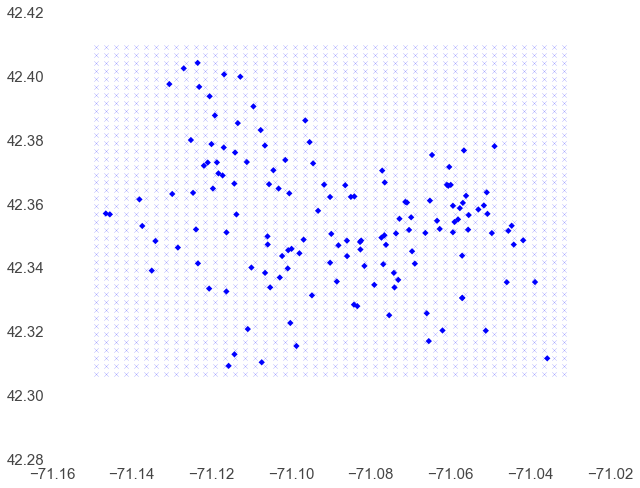

In [34]:
lats = LATS.reshape((-1,1))
lons = LONS.reshape((-1,1))
plt.figure()
plt.scatter(lons,lats,marker='x',alpha=0.45)
plt.scatter(stn_lons,stn_lats,marker='D')
plt.show()

In [35]:
stations_df.loc[stations_df.id==3][['lat','lng']].values[0]+np.random.uniform(-0.025,0.025,size=2)

array([ 42.36470302, -71.10690696])

In [36]:
def stationmap(weekday, hour, filedir=None, savefig=False, plot_seed = False):
    
    time_title = str(hour)+" AM" if hour < 12 else str(hour)+" PM" if hour == 12 else str(hour%12)+" PM"
    img_num = str(hour+1)
    while len(img_num)<3:
        img_num = "0"+img_num
    
    #filter dataframe for specified hour,compute the trips in and out, and store numbers of in and out trips lists
    weekday_hr =  weekday.loc[weekday.st_hour == hour ]
    statsout = weekday_hr.groupby('strt_statn',as_index=False)['seq_id'].count()
    statsin = weekday_hr.groupby('end_statn',as_index=False)['seq_id'].count()
    outtrips=statsout.seq_id.tolist()
    intrips=statsin.seq_id.tolist()
    
    #get list of stations, get their latitudes and longitudes, and store in list
    stationlistout=statsout.strt_statn.tolist()
    stationlistin=statsin.end_statn.tolist()
    stationsin = stations_df[stations_df['id'].isin(stationlistin)]
    stationsout = stations_df[stations_df['id'].isin(stationlistout)]
    latlistin =stationsin.lat.tolist()
    lonlistin =stationsin.lng.tolist()
    latlistout =stationsout.lat.tolist()
    lonlistout =stationsout.lng.tolist()
    
    #scale stations to emphasise relative numbers of in and out trips 
    tripsout = [t *1.0 / (max(outtrips) *1.0 )* 500.0 for t in outtrips]
    tripsin = [t *1.0 / (max(intrips) *1.0 )* 500.0 for t in intrips]

    #set up plot with mercator projection and coastline for context
    plt.figure()
#     plt.subplots(1,2,figsize=(19,12))   
#     plt.subplot(1, 2, 1)
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.drawmapboundary(fill_color='#F5F5F5',  linewidth=0)
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)
    
    # compute the native map projection coordinates for stations 
    xout,yout = m(lonlistout,latlistout)
    
    #plot trip departures using scaled circles at the station locations 
    m.scatter( xout, yout,  c=dark_colors[2], s=tripsout, marker='o', alpha=0.5,zorder = 2, label='Rentals')  
#     plt.title('Weekend Hubway Rentals at ' + time_title + '\n')
    
    #set up plot with mercator projection and coastline for context
#     plt.subplot(1, 2, 2)
#     m2=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
#     m2.drawmapboundary(fill_color='#F5F5F5', linewidth=0)
#     m2.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
#     poly = Polygon(m2.waterlyr[0], facecolor='#B5B5B5')
#     plt.gca().add_patch(poly)

    # compute the native map projection coordinates for stations 
    xin,yin = m(lonlistin,latlistin)

    #plot trip departures using scaled circles at the station locations 
    m.scatter( xin, yin,  c=dark_colors[3], s=tripsin, marker='o', zorder = 2, alpha=0.5,label="Returns")
    
    if plot_seed: # Plot the SA solved seed bikes.
        stn_st_ids = [3, 7, 8, 9, 11, 11, 12, 13, 14, 17, 18, 21, 21, 24, 24, 24, 27, 31, 33, 35, 35, 35, 36, 45, 45, 46, 47, 47, 49, 50, 52, 54, 54, 56, 56, 58, 60, 64, 67, 70, 74, 77, 78, 78, 80, 87, 88, 95, 97, 97]
        seed_locs = np.empty((len(stn_st_ids),2))
        for i_st in xrange(len(stn_st_ids)):
            seed_locs[i_st,:] = stations_df.loc[stations_df.id==stn_st_ids[i_st]][['lat','lng']].values[0]+np.random.uniform(-0.00075,0.00075,size=2)
        x_st, y_st = m(seed_locs[:,1],seed_locs[:,0])
        m.scatter(x_st, y_st,s=50,marker='x',color='black',lw=2,label="SA Bike Locations")
    
    
    plt.legend(loc=3)
    plt.title('Weekday Hubway Usage at ' + time_title + '\n')
    
    if savefig:
        return plt.savefig(filedir+'/PosterMap' + img_num)
    else:
        return plt.show()

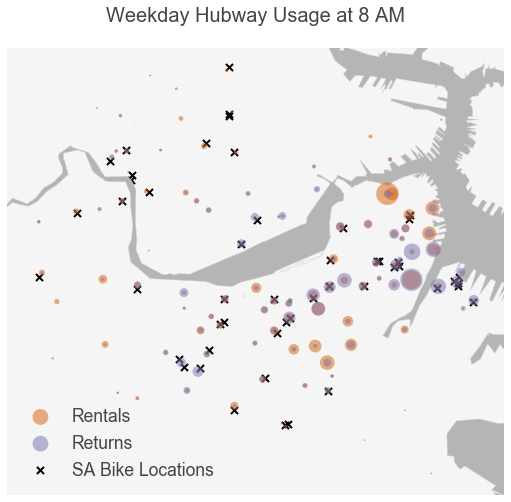

In [37]:
#call function to map stations
stationmap(weekdaystations, 8,filedir='Images',savefig=True,plot_seed=True)

Here we'll just plot and save the side by side comparison for all hours in a weekday/weekend.

/Users/ta24418/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


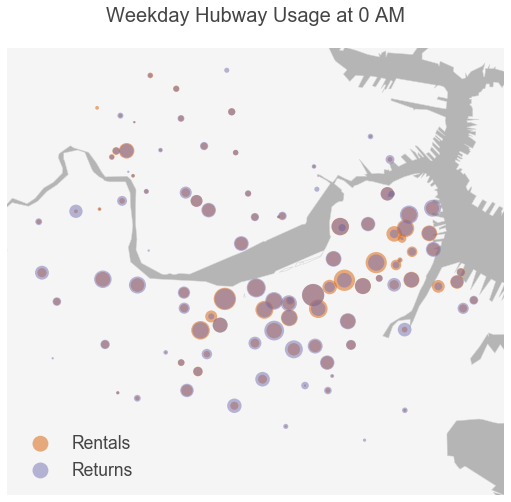

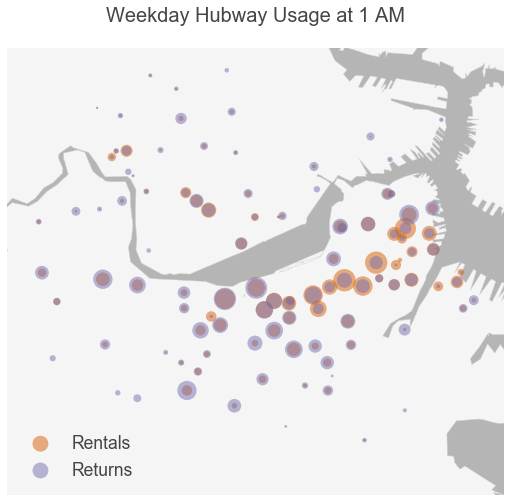

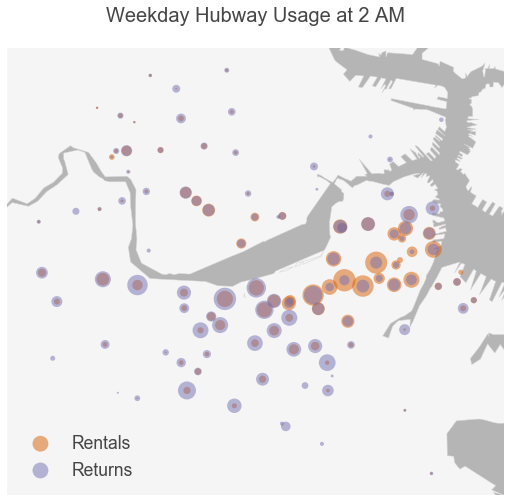

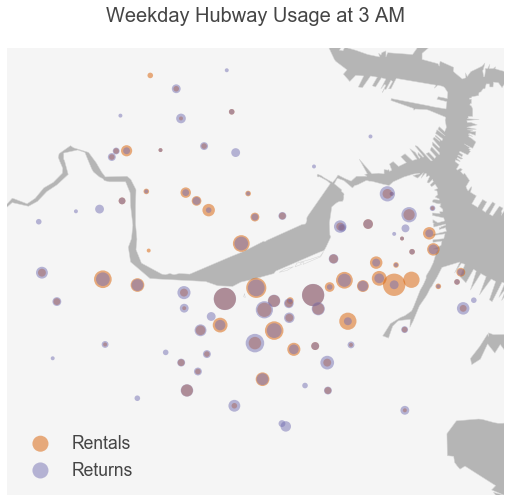

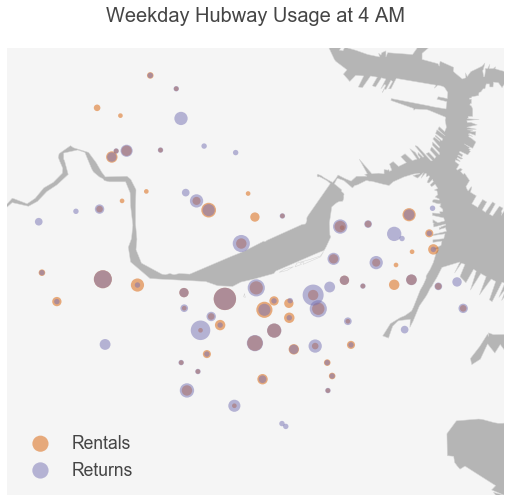

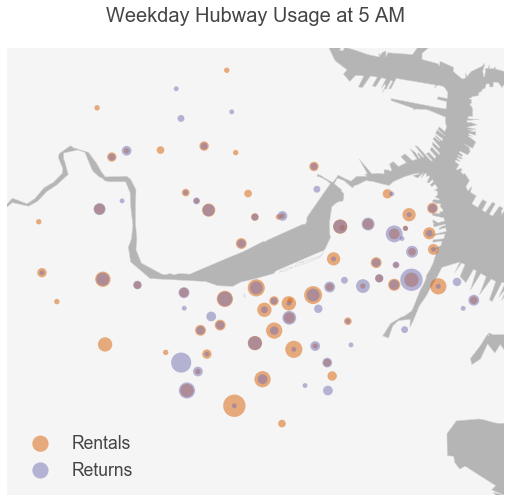

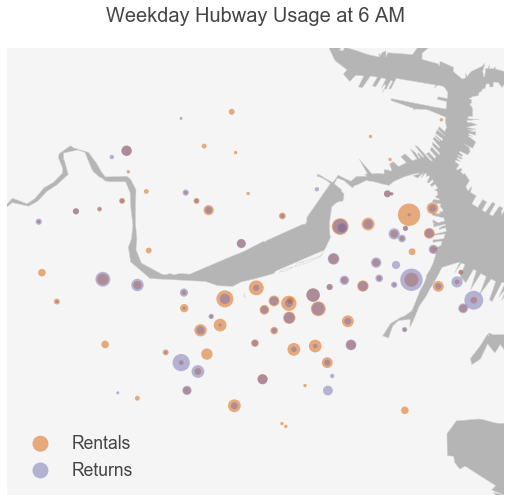

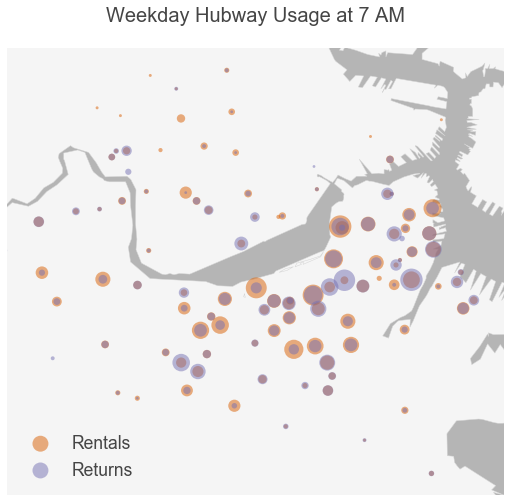

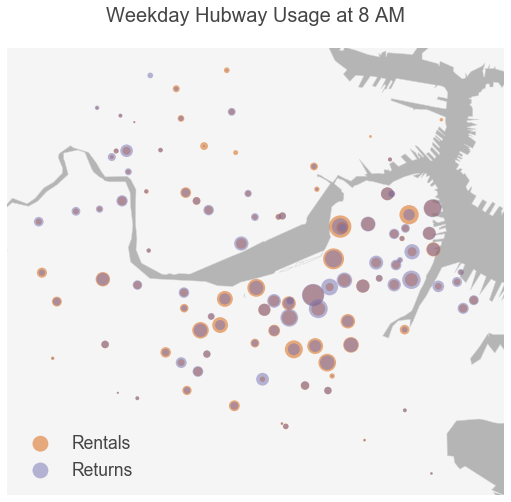

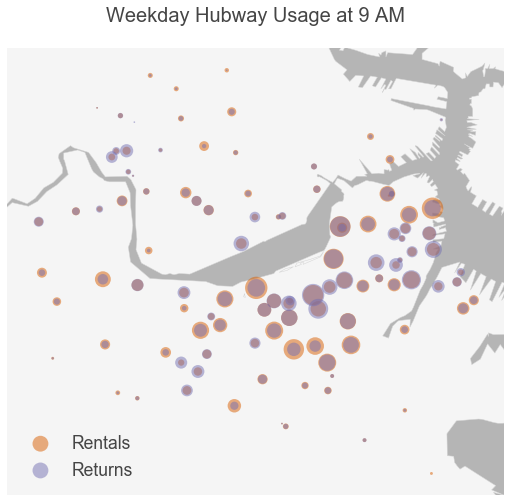

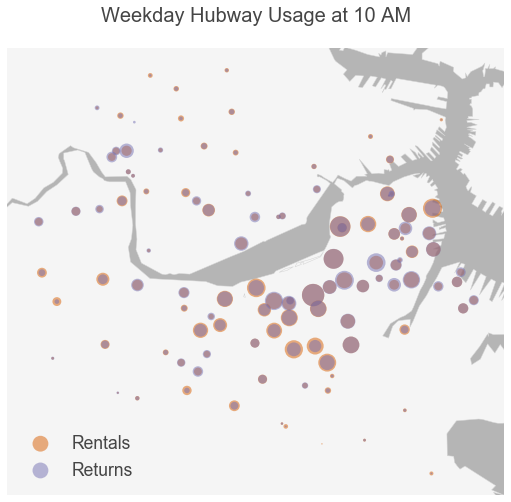

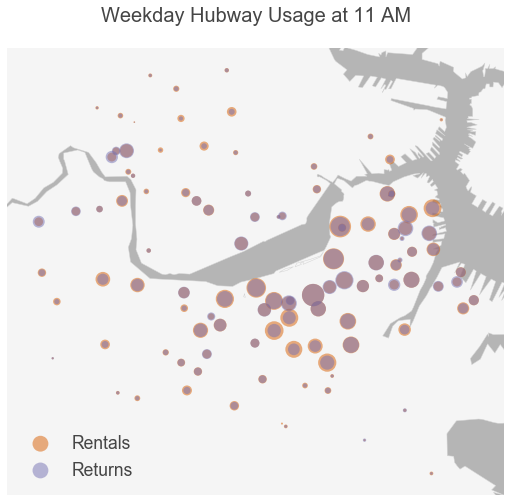

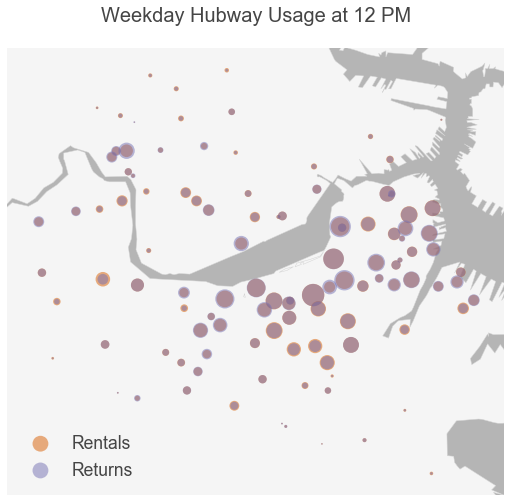

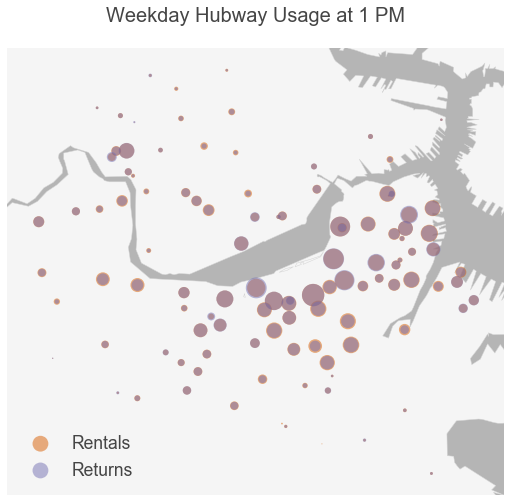

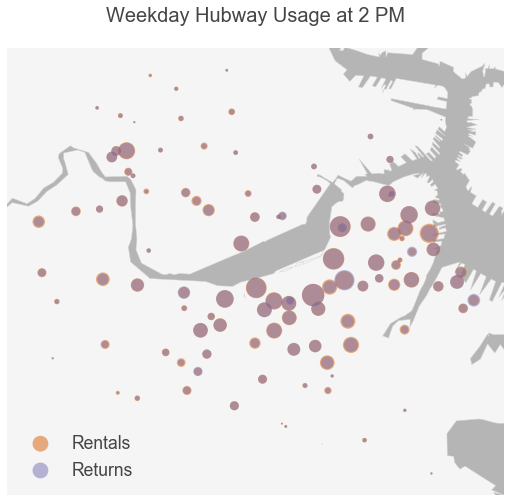

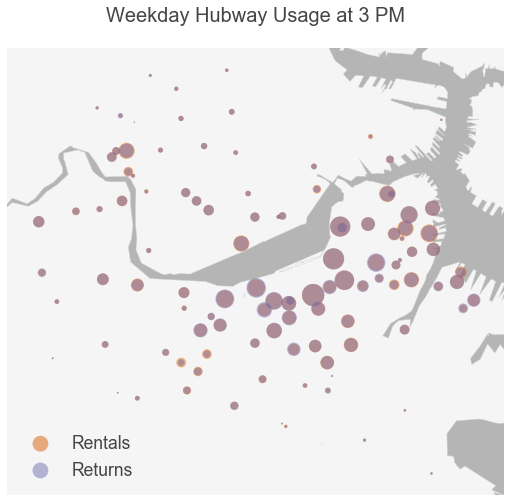

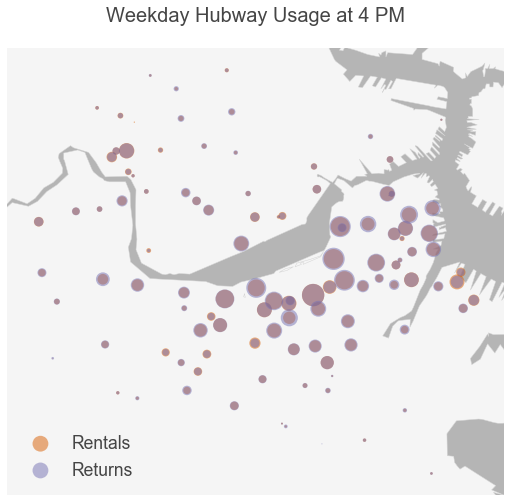

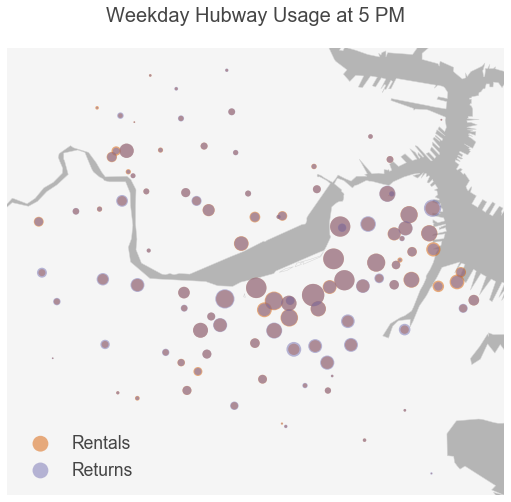

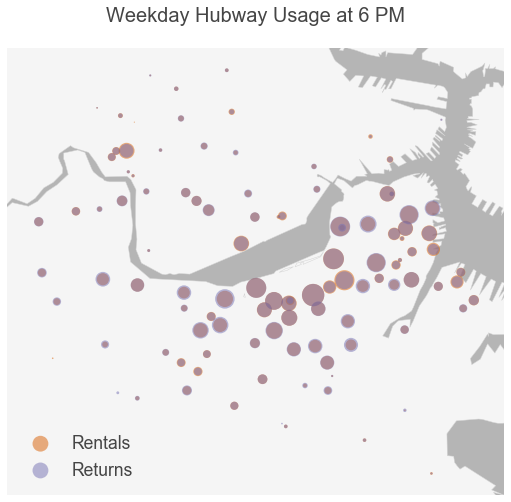

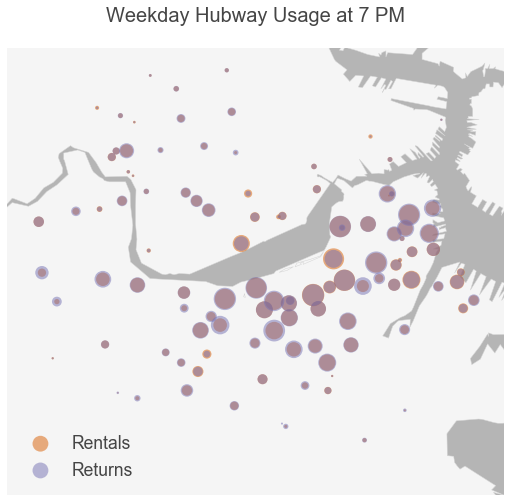

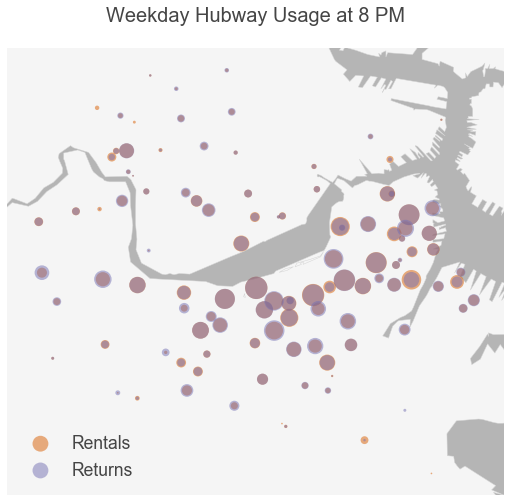

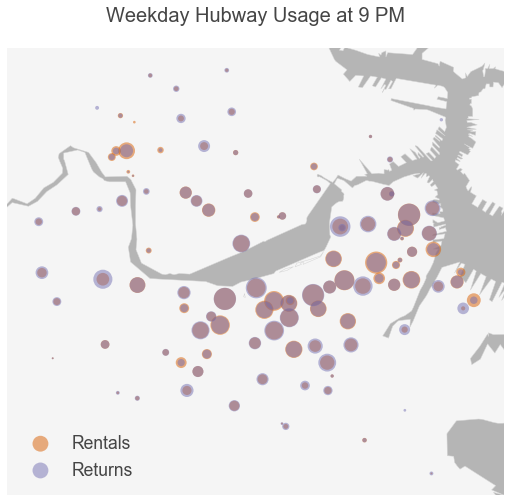

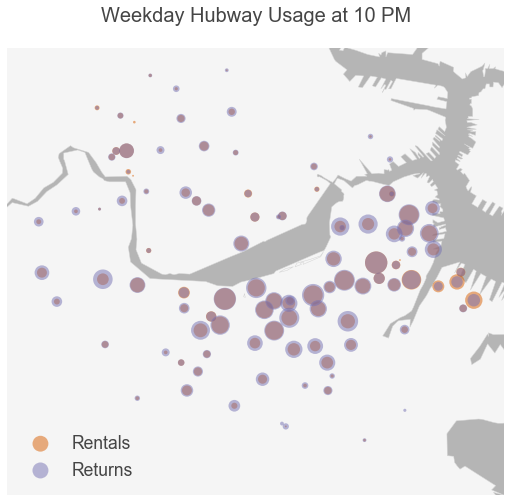

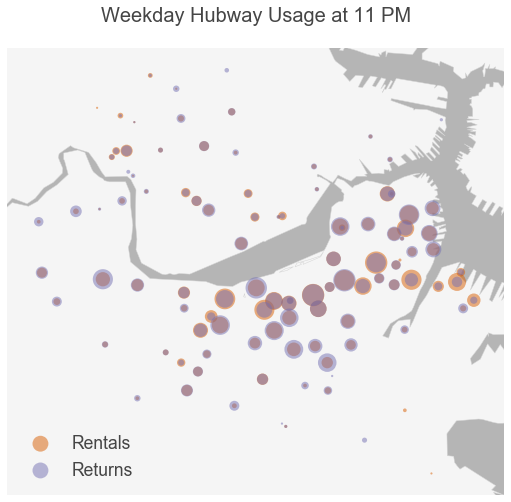

In [38]:
for hr in range(len(np.unique(trips_df.st_hour))):
    stationmap(weekendstations,hr,'weekend_inout_comb', True)

#### Now create the data that we'll use for hourly net station usage (weekdays)

In [39]:
def get_usage(weekday, hour):
    '''Helper function that pulls the data from each station at a given hour 
    and returns the net usage of each station in the system (rentals/returns)~(+/-)
    ------------------------------- INPUTS ---------------------------------------
    weekday: trips dataframe that is filtered based on being a weekday or weekend
    hour:    the specified hour over which we want to aggregate data
    ------------------------------- OUTPUT ---------------------------------------
    usage:   the net usage for each station in the system. If there is no information
             for any station in the given hour, a zero is returned.'''
    
    # Create array of zeros corresponding to each station
    usage = np.zeros(len(stations_df.station))
    
    #filter dataframe for specified hour,compute the trips in and out, and store numbers of in and out trips lists
    weekday_hr =  weekday.loc[weekday.st_hour == hour ]
    rentals = weekday_hr.groupby('strt_statn',as_index=False)['seq_id'].count().values
    returns = weekday_hr.groupby('end_statn',as_index=False)['seq_id'].count().values
    
    # Associate each station with the correct index
    for ii in range(len(rentals)):
        rent_id, rent_val = int(rentals[ii,0])-3, rentals[ii,1]
        usage[rent_id] += rent_val

    for jj in range(len(returns)):
        retu_id, retu_val = int(returns[jj,0])-3, returns[jj,1]
        usage[retu_id] -= retu_val
    
    return usage

In [40]:
X = np.concatenate((lons,lats),axis=1)
stns_gd = np.concatenate((np.array(stn_lons).reshape((-1,1)),np.array(stn_lats).reshape((-1,1))),axis=1)
X = np.concatenate((X,stns_gd),axis=0)
stn_usage = np.zeros((X.shape[0],len(np.unique(trips_df.st_hour))))

for hr in range(len(np.unique(trips_df.st_hour))):
    stn_usage[lons.shape[0]:,hr] = get_usage(weekdaystations,hr)

In [41]:
weekend_usage = np.zeros((X.shape[0],len(np.unique(trips_df.st_hour))))

for hr in range(len(np.unique(trips_df.st_hour))):
    weekend_usage[lons.shape[0]:,hr] = get_usage(weekendstations,hr)

#### Here's an example of a temporal (pre-GP sampling) look at what our usage is across the Hubway system, this is for 9 AM on a weekday

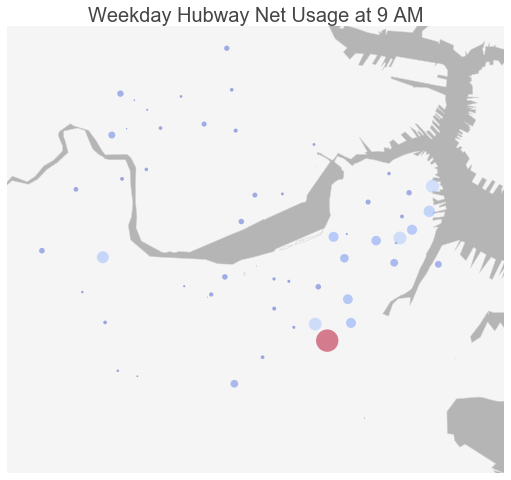

In [42]:
hr = 8
temp_usage = stn_usage[:,hr]
scaled_usage = np.copy(temp_usage)
scaled_usage[scaled_usage>=0] = [t*1.0/(np.max(np.abs(scaled_usage[scaled_usage>=0]))*1.0)*500.0 for t in scaled_usage[scaled_usage>=0]]
scaled_usage[scaled_usage<0] = [t*1.0/(np.max(np.abs(scaled_usage[scaled_usage<0]))*1.0)*500.0 for t in scaled_usage[scaled_usage<0]]

#set up plot with mercator projection and coastline for context
plt.figure()
m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
m.drawmapboundary(fill_color='#F5F5F5',  linewidth=0)
m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
plt.gca().add_patch(poly)

# compute the native map projection coordinates for stations 
xout,yout = m(X[:,0],X[:,1])
colors = np.copy(temp_usage)
colors[colors>=0] = [t*1.0/(np.max(np.abs(colors[colors>=0]))*1.0) for t in colors[colors>=0]]
colors[colors<0] = [t*1.0/(np.max(np.abs(colors[colors<0]))*1.0) for t in colors[colors<0]]
#plot trip departures using scaled circles at the station locations 
m.scatter( xout, yout,  c=colors, cmap='coolwarm', s=scaled_usage, marker='o', alpha=0.5,zorder = 2, vmin=0)  
plt.title('Weekday Hubway Net Usage at ' + str(hr+1)+ ' AM')

In [43]:
for hr in range(weekend_usage.shape[1]):
    
    time_title = str(hr)+" AM" if hr < 12 else str(hr)+" PM" if hr == 12 else str(hr%12)+" PM"
    img_num = str(hr+1)
    while len(img_num)<3:
        img_num = "0"+img_num
    
    temp_usage = weekend_usage[:,hr]
    scaled_usage = np.copy(temp_usage)
    scaled_usage[scaled_usage>=0] = [t*1.0/(np.max(np.abs(scaled_usage[scaled_usage>=0]))*1.0)*500.0 for t in scaled_usage[scaled_usage>=0]]
    scaled_usage[scaled_usage<0] = [t*1.0/(np.max(np.abs(scaled_usage[scaled_usage<0]))*1.0)*500.0 for t in scaled_usage[scaled_usage<0]]

    #set up plot with mercator projection and coastline for context
    plt.figure()
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.drawmapboundary(fill_color='#F5F5F5',  linewidth=0)
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    # compute the native map projection coordinates for stations 
    xout,yout = m(X[:,0],X[:,1])
    colors = np.copy(temp_usage)
    colors[colors>=0] = [t*1.0/(np.max(np.abs(colors[colors>=0]))*1.0) for t in colors[colors>=0]]
    colors[colors<0] = [t*1.0/(np.max(np.abs(colors[colors<0]))*1.0) for t in colors[colors<0]]
        
    #plot trip departures using scaled circles at the station locations 
    m.scatter( xout, yout,  c=colors, cmap='coolwarm', s=scaled_usage, marker='o', alpha=0.5,zorder = 2, vmin=0)  
    plt.title('Weekend Hubway Net Usage at ' + time_title+'\n')
    plt.savefig("weekend_usage/figure" + img_num)
    plt.close()

I took the batch of images saved above and converted them into a video file using ffmpeg (see readme for more information)

### Timeseries...
We need to group by station (both as origin and ending) and sort by timestamp +1s for outgoing bikes and -1s for incoming bikes (there needs to be a unified timestamp domain for the sake of consistency between stations)

I decided to gather two timeseries at different frequencies of time. The first is for every hour from March to November 2012. The second is for every day from March to November 2012

In [44]:
day_set = set(trips_df.st_daydate.tolist())
day_set |= set(trips_df.end_daydate.tolist())
day_set = list(day_set)

In [45]:
timeseries_matrix_day = np.zeros((len(stations_df),len(day_set)))
timeseries_matrix_day_in = np.zeros((len(stations_df),len(day_set)))
timeseries_matrix_day_out = np.zeros((len(stations_df),len(day_set)))
timeseries_matrix_hour = np.zeros((len(stations_df),len(day_set)*len(np.unique(trips_df.st_hour))))
timeseries_matrix_hour_in = np.zeros((len(stations_df),len(day_set)*len(np.unique(trips_df.st_hour))))
timeseries_matrix_hour_out = np.zeros((len(stations_df),len(day_set)*len(np.unique(trips_df.st_hour))))

In [46]:
print timeseries_matrix_day.shape
print timeseries_matrix_hour.shape

(142, 261)
(142, 6264)


In [47]:
for row in trips_df.iterrows():
#     print row[1][6], row[1][8], row[1][8]==row[1][8]
    if row[1][6] != row[1][6]:
        continue
    st_station_idx = int(row[1][6] - 3)
    st_day = day_set.index(row[1][20])
    st_idx = int(24*st_day + row[1][14])
    if row[1][8] != row[1][8]:
        continue
    end_station_idx = int(row[1][8] - 3)
    end_day = day_set.index(row[1][21])
    end_idx = int(24*end_day + row[1][15])
    
    timeseries_matrix_hour[st_station_idx,st_idx] += 1
    timeseries_matrix_hour_out[st_station_idx,st_idx] += 1
    timeseries_matrix_hour[end_station_idx,end_idx] -= 1
    timeseries_matrix_hour_in[end_station_idx,end_idx] += 1
    
    timeseries_matrix_day[st_station_idx,st_day] += 1
    timeseries_matrix_day_out[st_station_idx,st_day] += 1
    timeseries_matrix_day[end_station_idx,end_day] -= 1
    timeseries_matrix_day_in[end_station_idx,end_day] += 1
    

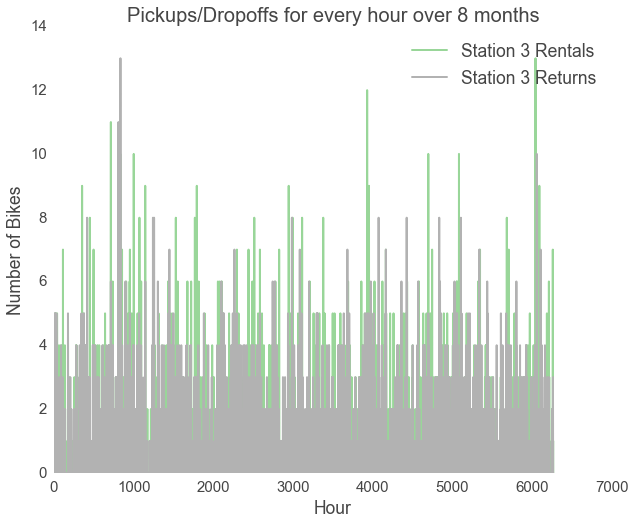

In [48]:
plt.figure()
plt.plot(timeseries_matrix_hour_out[0,:],label="Station 3 Rentals")
plt.plot(timeseries_matrix_hour_in[0,:],label="Station 3 Returns")
plt.title("Pickups/Dropoffs for every hour over 8 months")
plt.xlabel("Hour")
plt.ylabel("Number of Bikes")
plt.legend()
plt.show()

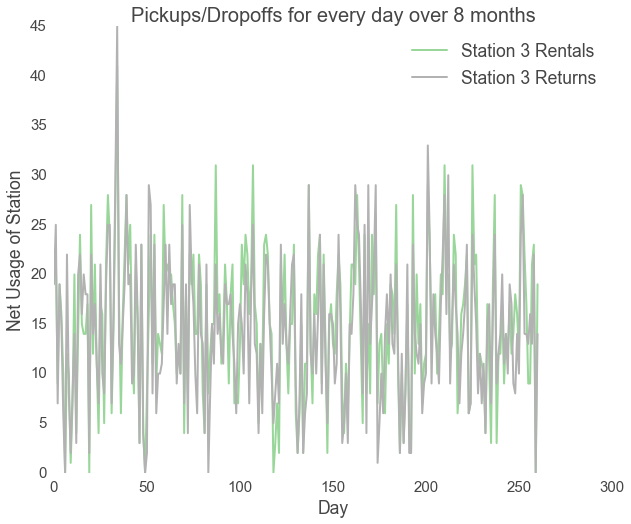

In [49]:
plt.figure()
plt.plot(timeseries_matrix_day_out[0,:],label="Station 3 Rentals")
plt.plot(timeseries_matrix_day_in[0,:],label="Station 3 Returns")
plt.title("Pickups/Dropoffs for every day over 8 months")
plt.xlabel("Day")
plt.ylabel("Net Usage of Station")
# plt.ylim([-15,15])
plt.legend()
plt.show()

In [50]:
with open("timeseries_hourly_rentals.npy",'w') as hr1:
    pickle.dump(timeseries_matrix_hour_out,hr1)
    
with open("timeseries_hourly_returns.npy",'w') as hr2:
    pickle.dump(timeseries_matrix_hour_in,hr2)

with open("timeseries_daily_rentals.npy",'w') as da1:
    pickle.dump(timeseries_matrix_day_out,da1)

with open("timeseries_daily_returns.npy",'w') as da2:
    pickle.dump(timeseries_matrix_day_in,da2)

### Here's an example of using the discrete minute/second time of every pickup and drop off for Station 3
(I quickly noticed that this was certainly not the right way to go about this... I switched to the less efficient but more cautious method above)

In [51]:
# Get unique domain for all possible times.
time_domain = set()
time_domain |= set(trips_df.start_date.tolist())
time_domain |= set(trips_df.end_date.tolist())
time_domain = sorted(list(time_domain))

In [52]:
station_timeseries = np.zeros(len(time_domain))

In [53]:
station3 = weekdaystations.loc[weekdaystations.strt_statn==3]
station3_start_times = station3.start_date.tolist()
station3_end_times = station3.end_date.tolist()

In [54]:
take_idx = [time_domain.index(time) for time in station3_start_times]
return_idx = [time_domain.index(time) for time in station3_end_times]

In [55]:
for ii in take_idx:
    station_timeseries[ii] += 1
for jj in return_idx:
    station_timeseries[jj] -= 1

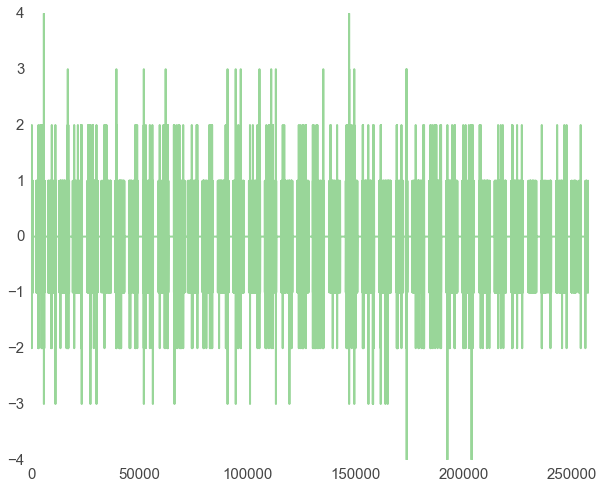

In [56]:
plt.figure()
plt.plot(station_timeseries)
plt.xlim([0,len(station_timeseries)])
plt.show()

In [57]:
station4 = weekdaystations.loc[weekdaystations.strt_statn==4]
station4_start_times = station4.start_date.tolist()
station4_end_times = station4.end_date.tolist()

In [58]:
take_idx4 = [time_domain.index(time)]